In [ ]:
# python 3.10.12
# !pip install -r requirements.txt

In [ ]:
import pandas as pd
import numpy as np
import json
import joblib
import pickle as pkl

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
import seaborn as sns
style.use("fivethirtyeight")
import folium
from folium.plugins import MarkerCluster
from matplotlib.colors import to_hex
from matplotlib import cm

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# 1. Introdução

Este notebook faz parte de um projeto mais amplo cujo objetivo é analisar dados de avaliações e estabelecimentos da plataforma Yelp, com foco na identificação de padrões de comportamento dos consumidores, fatores associados à percepção de qualidade e níveis de engajamento dos usuários.

Neste módulo específico, o foco está na segmentação de estabelecimentos por meio de técnicas de aprendizado não supervisionado, com o objetivo de identificar grupos de negócios com perfis semelhantes de desempenho e engajamento. A análise considera dois eixos centrais do ponto de vista de negócio: qualidade percebida, representada pela média de avaliações (stars), e nível de engajamento, representado pelo número de avaliações (review_count).

A segmentação permite transformar métricas contínuas em grupos interpretáveis, facilitando a geração de insights acionáveis, a comparação entre perfis de negócios e o suporte a estratégias de marketing, priorização e recomendação.

## Objetivos da Análise de Cluster

As análises conduzidas neste notebook têm como objetivos principais:

- Identificar grupos distintos de estabelecimentos com base em avaliação média e volume de engajamento;

- Caracterizar o perfil de cada cluster em termos de qualidade percebida e popularidade;

- Analisar a distribuição das principais categorias de negócio em cada segmento;

- Gerar insights que possam apoiar estratégias de segmentação, posicionamento e tomada de decisão.

## Organização do Projeto

O projeto está estruturado de forma modular, com notebooks e componentes que podem ser analisados de maneira independente, garantindo reprodutibilidade e clareza na apresentação dos resultados.

Além deste notebook, o projeto inclui os seguintes módulos:

- **Análise de Clusters**: segmentação dos estabelecimentos com base em métricas de avaliação e engajamento;
- **Classificação Supervisionada**: análise de sentimento das avaliações textuais por meio de modelos de machine learning;
- **Dashboard Interativo**: visualização dos principais insights para apoio à tomada de decisão.

A preparação e limpeza dos dados utilizados nas análises foram realizadas no notebook "EDA_inferencial.ipynb".

# 2. Prepação dos Dados

Foram selecionadas as variáveis stars e review_count como representações diretas de qualidade percebida e engajamento dos usuários.
Devido à forte assimetria da variável review_count, foi aplicada a transformação logarítmica (log1p), com o objetivo de reduzir o impacto de valores extremos e tornar a distribuição mais adequada à modelagem.

Em seguida, as variáveis foram padronizadas por meio do StandardScaler, garantindo comparabilidade entre escalas e evitando que uma variável dominasse o processo de clusterização.

In [ ]:
df_business = pd.read_json('df_business_tennessee_cleaned.json', lines=True)
df_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12056 entries, 0 to 12055
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   business_id    12056 non-null  object 
 1   name           12056 non-null  object 
 2   address        12056 non-null  object 
 3   city           12056 non-null  object 
 4   state          12056 non-null  object 
 5   postal_code    12056 non-null  object 
 6   latitude       12056 non-null  float64
 7   longitude      12056 non-null  float64
 8   stars          12056 non-null  float64
 9   review_count   12056 non-null  int64  
 10  is_open        12056 non-null  int64  
 11  attributes     10996 non-null  object 
 12  categories     12051 non-null  object 
 13  hours          10398 non-null  object 
 14  main_category  12056 non-null  object 
 15  subcategories  12051 non-null  object 
 16  analysis       12056 non-null  object 
 17  total_hours    12056 non-null  float64
 18  cleane

In [ ]:
# Transformação da coluna 'review_count' para log devido a distribuição
df_business['log_review_count'] = np.log1p(df_business['review_count'])

# Seleção de variáveis para clustering
df_clustering = df_business[['log_review_count', 'stars']]

# Padronização dos dados numéricos
scaler = StandardScaler()
df_clustering_scaled = scaler.fit_transform(df_clustering)

# 3. Metodologia de Clusterização

O processo de segmentação seguiu as seguintes etapas:

**1. Definição do número de clusters**
Foram utilizados o Elbow Method e a métrica de Silhouette Score para avaliar diferentes valores de k. Ambos os métodos indicaram k = 3 como o número mais adequado de agrupamentos, considerando equilíbrio entre coesão interna e separação entre clusters.

**2. Aplicação do algoritmo**
O algoritmo K-Means foi aplicado sobre os dados padronizados. Para cada cluster, foram calculadas estatísticas descritivas (média e desvio padrão) das variáveis utilizadas, permitindo a caracterização dos perfis identificados.

**3. Análise de categorias de negócio**
Foi analisada a distribuição das principais categorias (main_category) em cada cluster, com o objetivo de compreender quais tipos de negócios tendem a se concentrar em determinados perfis de avaliação e engajamento.

**4. Visualização dos resultados**
Para facilitar a interpretação dos agrupamentos, foi utilizado um gráfico de dispersão com os clusters por número de avaliações e estrelas.

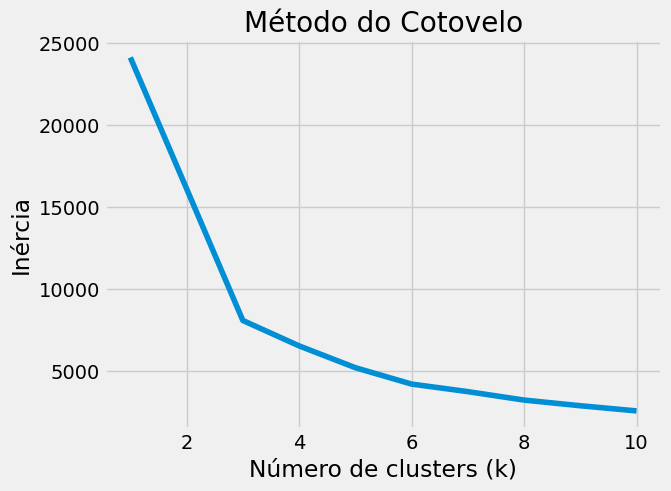

In [ ]:
# Escolher o número de clusters (k) usando o método do cotovelo
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_clustering_scaled)
    inertia.append(kmeans.inertia_)

# Plotando o gráfico do cotovelo
plt.plot(range(1, 11), inertia)
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.show()

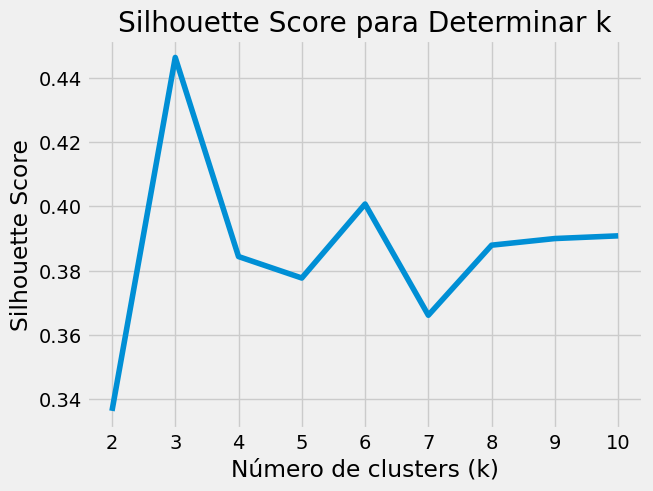

In [ ]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_clustering_scaled)
    labels = kmeans.labels_
    score = silhouette_score(df_clustering_scaled, labels)
    silhouette_scores.append(score)

# Plotar os scores de silhouette
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score para Determinar k')
plt.show()

            stars           log_review_count          
             mean       std             mean       std
cluster                                               
0        2.337702  0.590615         2.691108  0.665711
1        4.243119  0.538628         2.482639  0.520845
2        3.824503  0.585653         4.601798  0.813539


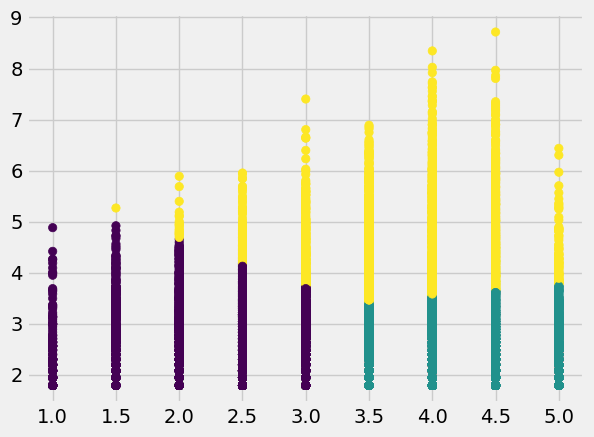

In [ ]:
# Seleção do valor de k (com base no gráfico)
k = 3

# Execução do K-Means com o valor de k escolhido
kmeans = KMeans(n_clusters=k, random_state=42)
df_business['cluster'] = kmeans.fit_predict(df_clustering_scaled)

# Análise dos clusters
cluster_summary = df_business.groupby('cluster').agg({
    'stars': ['mean', 'std'],
    'log_review_count': ['mean', 'std'],
})

# Exibindo o resumo dos clusters
print(cluster_summary)

# Visualização dos clusters
plt.scatter(
    df_business['stars'],
    df_business['log_review_count'],
    c=df_business['cluster'],
    cmap='viridis'
)

In [ ]:
# Principais estatísticas dos clusters
stats = df_business.groupby('cluster').agg(
    mean_stars=('stars', 'mean'),
    std_stars=('stars', 'std'),
    mean_review_count=('review_count', 'mean'),
    std_review_count=('review_count', 'std'),
    n_businesses=('review_count', 'count')
)
print(stats)

         mean_stars  std_stars  mean_review_count  std_review_count  \
cluster                                                               
0          2.337702   0.590615          17.768823         15.139476   
1          4.243119   0.538628          12.787706          7.756472   
2          3.824503   0.585653         153.901656        256.808965   

         n_businesses  
cluster                
0                3586  
1                5450  
2                3020  


# 4. Resultados e Interpretação

**Cluster 0 — Baixa avaliação e baixo engajamento**

- Média de estrelas: 2,34

- Número médio de avaliações: 17,77

- Quantidade de negócios: 3.586

Este grupo reúne negócios com baixa qualidade percebida e baixo engajamento dos consumidores, indicando dificuldades tanto na experiência oferecida quanto na capacidade de gerar interação. Estratégias voltadas à melhoria de produtos/serviços, treinamento de equipes e fortalecimento da percepção de marca podem ser prioritárias para este segmento.

**Cluster 1 — Alta avaliação e baixo engajamento**

- Média de estrelas: 4,24

- Número médio de avaliações: 12,79

- Quantidade de negócios: 5.450

Os negócios deste cluster apresentam excelente avaliação, mas ainda baixa visibilidade ou alcance, o que limita o volume de avaliações. Esse padrão sugere oportunidades para ações de marketing digital, incentivo à participação dos clientes e fortalecimento da presença online, de modo a ampliar o engajamento sem comprometer a qualidade percebida.

**Cluster 2 — Boa avaliação e alto engajamento**

- Média de estrelas: 3,82

- Número médio de avaliações: 153,90 (com alta dispersão)

- Quantidade de negócios: 3.020

Este cluster concentra negócios com bom desempenho geral e alto nível de interação com os usuários. A elevada dispersão no número de avaliações indica heterogeneidade interna, mas, de forma geral, esses estabelecimentos já possuem uma base de clientes ativa. Estratégias focadas em retenção, consistência da experiência e fidelização tendem a ser mais relevantes para este grupo.

**Considerações adicionais**

A análise das categorias principais mostrou que todas estão representadas nos três clusters, indicando que o desempenho dos negócios não depende exclusivamente do setor, mas também de fatores como gestão, experiência do cliente e engajamento digital.

# 5. Conclusão


## Síntese da Análise

Nesta etapa do projeto, foi aplicada uma abordagem de aprendizado não supervisionado para segmentar os estabelecimentos da plataforma Yelp com base em dois eixos centrais do negócio: qualidade percebida (stars) e nível de engajamento dos usuários (review_count).

Após o tratamento da assimetria da variável de engajamento por meio de transformação logarítmica e a padronização dos dados, o algoritmo K-Means foi utilizado para identificar padrões latentes no comportamento dos estabelecimentos. A escolha de três clusters mostrou-se adequada tanto do ponto de vista estatístico (Elbow Method e Silhouette Score) quanto interpretativo.

Os clusters obtidos são coerentes, bem separados e facilmente interpretáveis, permitindo a caracterização de perfis distintos de negócios dentro da plataforma.

## Impacto do Projeto e Recomendações Estratégicas

A segmentação obtida oferece valor direto para a tomada de decisão, ao permitir estratégias diferenciadas conforme o perfil de cada grupo:
- Negócios com baixa avaliação e baixo engajamento podem ser priorizados em iniciativas de melhoria da experiência do cliente, revisão de processos operacionais e capacitação, reduzindo riscos de churn e avaliações negativas.

- Negócios bem avaliados, porém com baixo engajamento, representam oportunidades estratégicas para ações de marketing, maior visibilidade na plataforma e estímulo à geração de avaliações, ampliando alcance sem comprometer a percepção de qualidade.

- Negócios com boa avaliação e alto engajamento configuram o segmento mais consolidado, no qual estratégias de retenção, fidelização e consistência da experiência tendem a gerar maior retorno.

Adicionalmente, a presença de todas as categorias principais nos diferentes clusters reforça que o desempenho dos estabelecimentos não depende exclusivamente do setor, mas de fatores como gestão, experiência do usuário e engajamento digital — um insight relevante para estratégias transversais da plataforma.

## Próximos Passos e Possíveis Extensões do Projeto

Como evolução natural deste trabalho, destacam-se os seguintes caminhos:

- Incorporação de novas variáveis no processo de clusterização, como:

  - Atributos operacionais (hours, atributos específicos por categoria),

  - Variáveis textuais agregadas das avaliações,

  - Métricas temporais de crescimento de engajamento.

- Aplicação de algoritmos mais adequados a dados mistos, como K-Prototypes, permitindo combinar variáveis numéricas e categóricas de forma mais rica.

- Integração com os módulos de análise de sentimento, utilizando informações textuais para enriquecer a segmentação e capturar nuances qualitativas da percepção dos clientes.

- Uso dos clusters como insumo para sistemas de recomendação ou priorização, apoiando decisões automatizadas de destaque, campanhas ou intervenções na plataforma.

Essas extensões reforçam o potencial do projeto como uma solução analítica escalável, conectando análise exploratória, modelagem não supervisionada e aplicações práticas orientadas ao negócio.

# 6. Preparação para deploy no dashboard

Nesta seção, são consolidados os artefatos necessários para a integração dos resultados analíticos com o dashboard interativo do projeto.

São preparados os dados finais e os outputs do modelo (incluindo rótulos de clusterização) de forma padronizada e serializada, garantindo reprodutibilidade, separação de responsabilidades e facilidade de consumo pela camada de visualização.

Essa etapa estabelece a ponte entre as análises exploratórias, inferenciais e de modelagem e a aplicação final orientada ao negócio, permitindo que os insights gerados sejam disponibilizados de maneira interativa, escalável e alinhada a um possível cenário de deploy.

In [ ]:
df_business.to_parquet("df_business_cluster.parquet")

In [ ]:
X = df_business[["stars", "review_count"]]

cluster_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3, random_state=42))
])

cluster_pipeline.fit(X)

joblib.dump(cluster_pipeline, "cluster_pipeline.pkl")

['cluster_pipeline.pkl']